In [1]:
# This script needs these libraries to be installed: 
#   numpy, xgboost

import wandb
from wandb.xgboost import WandbCallback
import numpy as np
import xgboost as xgb
import utils
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import itertools
import matplotlib.dates as mdates
import pandas as pd

warnings.filterwarnings('ignore')


# Loading & Preprocessing Data

In [2]:
df = utils.load_data()
df = utils.log_transformation(df)
df = utils.break_datetime(df)
df = df[df['site_id'].isin([1, 6])]
df = utils.nan_weather_filler(df)
df.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,sea_level_pressure,wind_direction,wind_speed,log_meter_reading,log_square_feet,year,weekofyear,dayofweek,month,hour
11199,105,2016-01-01 08:00:00,46.1071,1,Education,50623,NaN,5.0,2.2,0.0,...,1022.3,60.0,1.0,3.852424,10.832181,2015,53,5,1,8
11200,106,2016-01-01 08:00:00,0.7492,1,Education,5374,NaN,4.0,2.2,0.0,...,1022.3,60.0,1.0,0.559159,8.589514,2015,53,5,1,8
11201,107,2016-01-01 08:00:00,350.3670,1,Education,97532,2005.0,10.0,2.2,0.0,...,1022.3,60.0,1.0,5.861831,11.487946,2015,53,5,1,8
11202,108,2016-01-01 08:00:00,182.5310,1,Education,81580,1913.0,5.0,2.2,0.0,...,1022.3,60.0,1.0,5.212384,11.309352,2015,53,5,1,8
11203,109,2016-01-01 08:00:00,164.3510,1,Education,56995,1953.0,6.0,2.2,0.0,...,1022.3,60.0,1.0,5.108070,10.950736,2015,53,5,1,8


In [3]:
# encoding 
df = utils.circular_encode(df,'month', 12)
df = utils.label_encode(df,'primary_use')
df.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,log_meter_reading,log_square_feet,year,weekofyear,dayofweek,month,hour,month_sin,month_cos,primary_use_encoded
11199,105,2016-01-01 08:00:00,46.1071,1,Education,50623,NaN,5.0,2.2,0.0,...,3.852424,10.832181,2015,53,5,1,8,0.5,0.866025,0
11200,106,2016-01-01 08:00:00,0.7492,1,Education,5374,NaN,4.0,2.2,0.0,...,0.559159,8.589514,2015,53,5,1,8,0.5,0.866025,0
11201,107,2016-01-01 08:00:00,350.3670,1,Education,97532,2005.0,10.0,2.2,0.0,...,5.861831,11.487946,2015,53,5,1,8,0.5,0.866025,0
11202,108,2016-01-01 08:00:00,182.5310,1,Education,81580,1913.0,5.0,2.2,0.0,...,5.212384,11.309352,2015,53,5,1,8,0.5,0.866025,0
11203,109,2016-01-01 08:00:00,164.3510,1,Education,56995,1953.0,6.0,2.2,0.0,...,5.108070,10.950736,2015,53,5,1,8,0.5,0.866025,0


In [4]:
# Add holidays
df = utils.apply_holidays(df)
df.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,log_square_feet,year,weekofyear,dayofweek,month,hour,month_sin,month_cos,primary_use_encoded,is_holiday
11199,105,2016-01-01 08:00:00,46.1071,1,Education,50623,NaN,5.0,2.2,0.0,...,10.832181,2015,53,5,1,8,0.5,0.866025,0,1
11200,106,2016-01-01 08:00:00,0.7492,1,Education,5374,NaN,4.0,2.2,0.0,...,8.589514,2015,53,5,1,8,0.5,0.866025,0,1
11201,107,2016-01-01 08:00:00,350.3670,1,Education,97532,2005.0,10.0,2.2,0.0,...,11.487946,2015,53,5,1,8,0.5,0.866025,0,1
11202,108,2016-01-01 08:00:00,182.5310,1,Education,81580,1913.0,5.0,2.2,0.0,...,11.309352,2015,53,5,1,8,0.5,0.866025,0,1
11203,109,2016-01-01 08:00:00,164.3510,1,Education,56995,1953.0,6.0,2.2,0.0,...,10.950736,2015,53,5,1,8,0.5,0.866025,0,1


# XGB Model

In [66]:
features = ['hour','month_sin','month_cos','log_square_feet', 'primary_use_encoded','is_holiday']
target = 'log_meter_reading'

In [67]:
df=df.sort_values(by='timestamp')

# Create WandB Project

In [7]:
wandb.init(project='XGB_Grid_Search', entity='foresquad')

# Define the hyperparameter values for grid search
max_depth_values = [3, 5, 8]
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.05, 0.1]

# Perform grid search
best_params = None
best_mse = float('inf')

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(max_depth_values, n_estimators_values, learning_rate_values))

for params in hyperparameter_combinations:
    max_depth, n_estimators, learning_rate = params

    # Split data for time series
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize metrics
    mse_scores = []

    i = 1
    # Perform time series cross-validation
    for train_index, val_index in tscv.split(df):

        if i==5:
            break;
        
        train_data, val_data = df.iloc[train_index], df.iloc[val_index]
        X_train, y_train = train_data[features], train_data[target]
        X_val, y_val = val_data[features], val_data[target]

        # Train XGBoost model
        model = xgb.XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            objective='reg:squarederror'  # Specify the appropriate objective for regression
        )
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

        # Make predictions
        y_pred = model.predict(X_val)

        # Calculate mean squared error
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    # Compute the average MSE over folds
    average_mse = sum(mse_scores) / len(mse_scores)

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate, "mse": average_mse})

    # Update best hyperparameters if current configuration is better
    if average_mse < best_mse:
        best_mse = average_mse
        best_params = {"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate}
    
    i = i + 1

# Log the best hyperparameters and metrics after grid search
wandb.log({"Best Hyperparameters": best_params, "Best Mean Squared Error": best_mse})
wandb.finish()  # Finish the W&B run to ensure logs are flushed before the script exits


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [68]:
MSE_train = []
R2_train = []
MAE_train = []

MSE_test = []
R2_test = []
MAE_test = []

In [69]:

models = []
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits
# Create an empty dictionary to store results
results_dict = {'fold': [], 'train_mse': [], 'train_r2': [], 'train_mae': [],
                'test_mse': [], 'test_r2': [], 'test_mae': []}

i = 1
for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ',df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ',df_test['timestamp'].min(), df_test['timestamp'].max()) 
    i = i + 1 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression problems
    n_estimators=150,               # Number of boosting rounds (adjust as needed)
    learning_rate=0.1,              # Step size shrinkage to prevent overfitting
    max_depth=5                    # Maximum depth of each tree (adjust as needed)
    )

    XGB.fit(X_train,y_train)
    models.append(XGB)
    
    y_pred_train = XGB.predict(X_train)
    train_error_mse = mean_squared_error(y_train,y_pred_train)
    train_error_r2 = r2_score(y_train,y_pred_train)
    train_error_mae = mean_absolute_error(y_train,y_pred_train)

    print("MSE for train set is: ",train_error_mse)

    print("R2 for train set is: ",train_error_r2)

    print("MAE for train set is: ",train_error_mae)

    y_pred_test = XGB.predict(X_test)
    test_error_mse = mean_squared_error(y_test,y_pred_test)
    test_error_r2 = r2_score(y_test,y_pred_test)
    test_error_mae = mean_absolute_error(y_test,y_pred_test)


    print("MSE for test set is: ",test_error_mse)

    print("R2 for test set is: ",test_error_r2)

    print("MAE for test set is: ",test_error_mae)

    print("--------------------------------")

    MSE_train.append(train_error_mse)
    R2_train.append(train_error_r2)
    MAE_train.append(train_error_mae)

    MSE_test.append(test_error_mse)
    R2_test.append(test_error_r2)
    MAE_test.append(test_error_mae)

    # Store results in the dictionary
    results_dict['fold'].append(i)
    results_dict['train_mse'].append(train_error_mse)
    results_dict['train_r2'].append(train_error_r2)
    results_dict['train_mae'].append(train_error_mae)
    results_dict['test_mse'].append(test_error_mse)
    results_dict['test_r2'].append(test_error_r2)
    results_dict['test_mae'].append(test_error_mae)



fold : 1
Train:  2016-01-01 08:00:00 2016-03-02 16:00:00
Test:  2016-03-02 16:00:00 2016-05-03 09:00:00
MSE for train set is:  0.019954281126952272
R2 for train set is:  0.985292544740981
MAE for train set is:  0.09504600312554173
MSE for test set is:  0.12924592636338325
R2 for test set is:  0.9104983586549091
MAE for test set is:  0.17364456112714594
--------------------------------
fold : 2
Train:  2016-01-01 08:00:00 2016-05-03 09:00:00
Test:  2016-05-03 09:00:00 2016-07-01 13:00:00
MSE for train set is:  0.02407933171870771
R2 for train set is:  0.9828377880466581
MAE for train set is:  0.10041917657625521
MSE for test set is:  0.2882365319463458
R2 for test set is:  0.8395511565291911
MAE for test set is:  0.20929297792357865
--------------------------------
fold : 3
Train:  2016-01-01 08:00:00 2016-07-01 13:00:00
Test:  2016-07-01 13:00:00 2016-08-31 18:00:00
MSE for train set is:  0.04195141600005409
R2 for train set is:  0.9726983734676946
MAE for train set is:  0.116605628874

In [70]:
# Convert the dictionary to a DataFrame for easy handling and visualization
XGBresults_df = pd.DataFrame(results_dict)
print(XGBresults_df)
# Save the DataFrame to a CSV file
XGBresults_df.to_csv('XGB_results.csv', index=False)

   fold  train_mse  train_r2  train_mae  test_mse   test_r2  test_mae
0     2   0.019954  0.985293   0.095046  0.129246  0.910498  0.173645
1     3   0.024079  0.982838   0.100419  0.288237  0.839551  0.209293
2     4   0.041951  0.972698   0.116606  0.188160  0.900108  0.213149
3     5   0.050974  0.968667   0.123706  0.119672  0.926081  0.188221
4     6   0.051451  0.968343   0.127417  0.395356  0.705418  0.243802


fold : 1
Train:  2016-01-01 08:00:00 2016-03-02 16:00:00
Test:  2016-03-02 16:00:00 2016-05-03 09:00:00


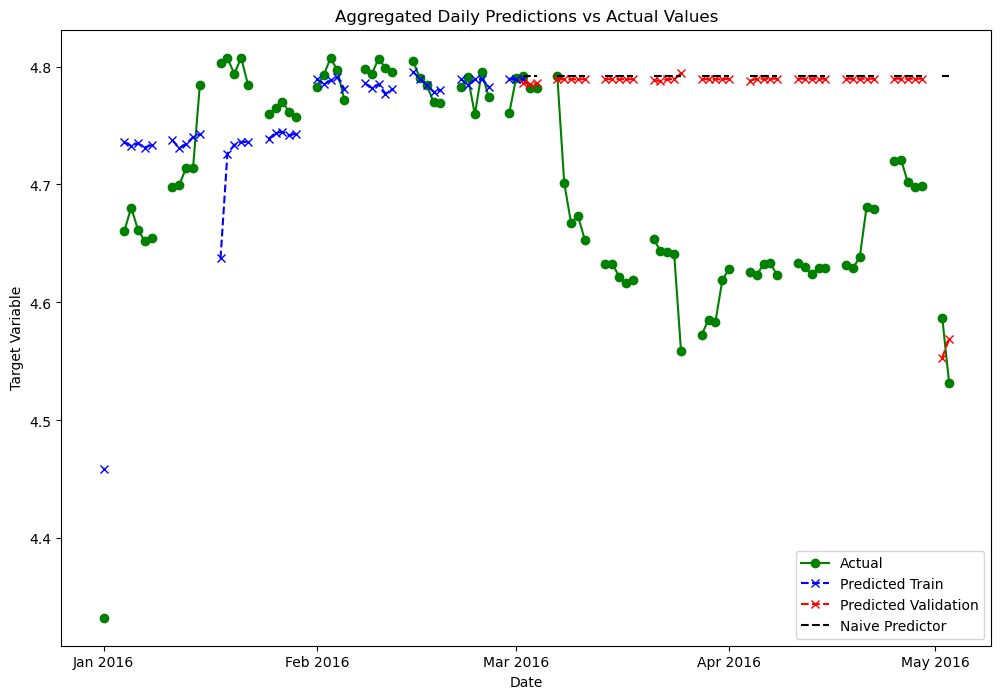

fold : 2
Train:  2016-01-01 08:00:00 2016-05-03 09:00:00
Test:  2016-05-03 09:00:00 2016-07-01 13:00:00


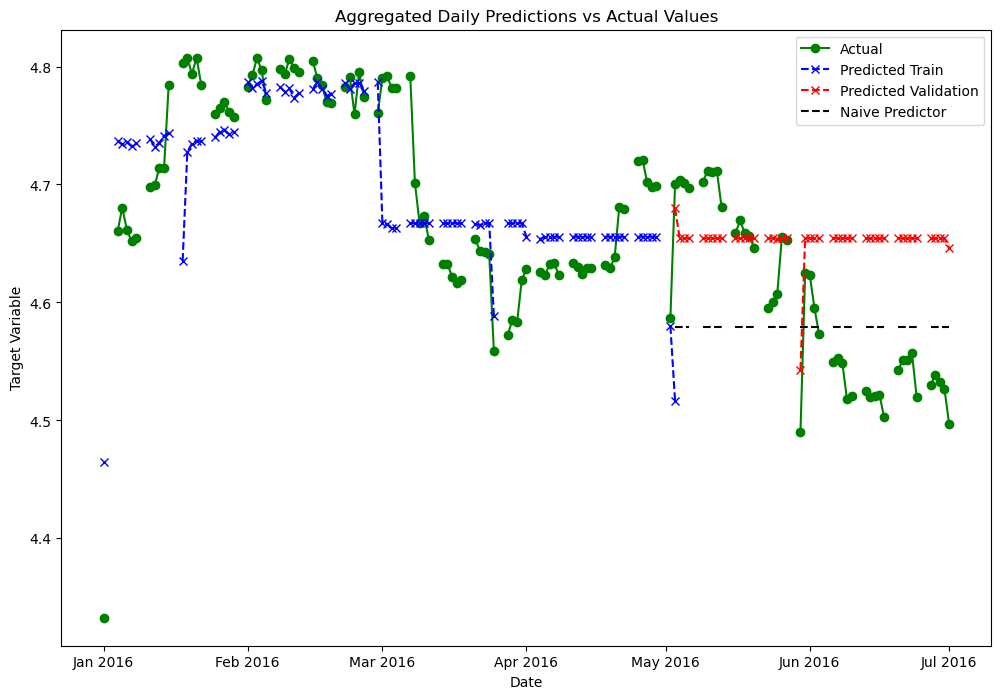

fold : 3
Train:  2016-01-01 08:00:00 2016-07-01 13:00:00
Test:  2016-07-01 13:00:00 2016-08-31 18:00:00


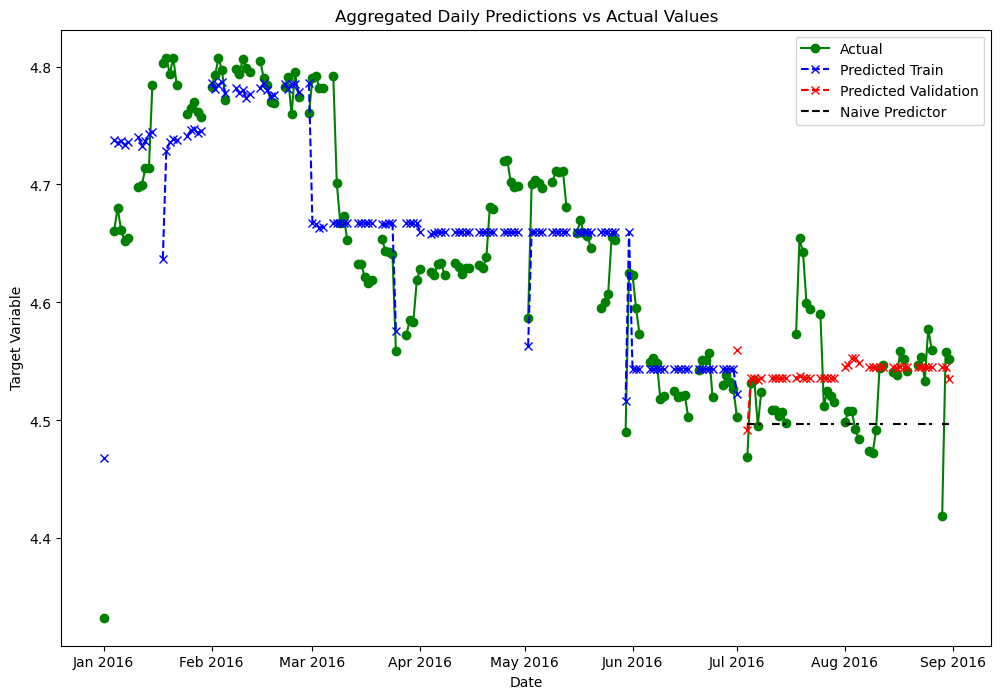

fold : 4
Train:  2016-01-01 08:00:00 2016-08-31 18:00:00
Test:  2016-08-31 18:00:00 2016-11-01 12:00:00


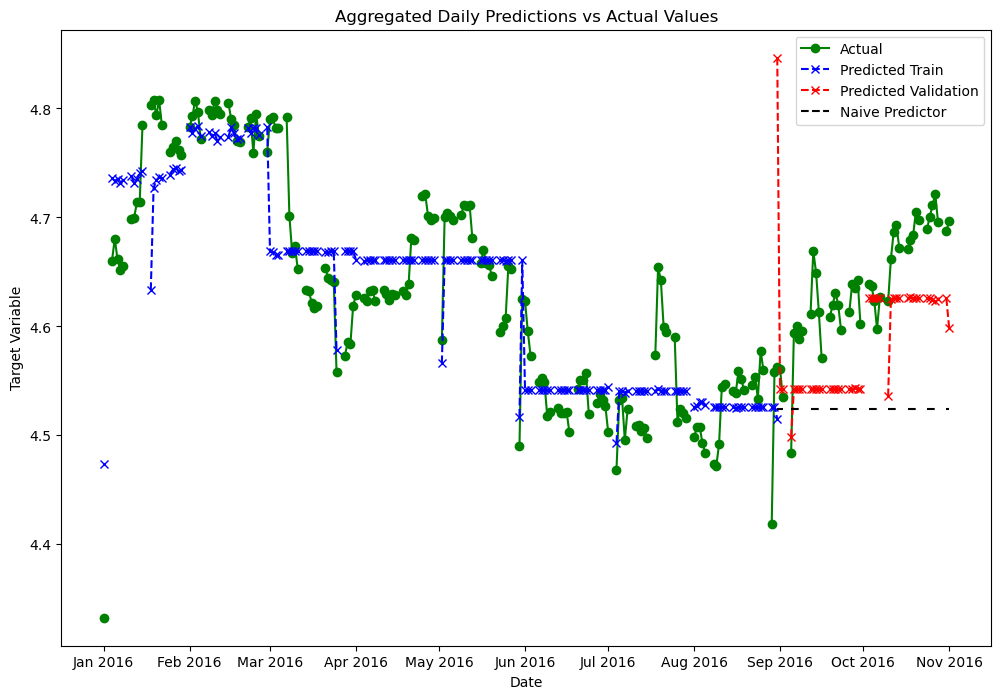

fold : 5
Train:  2016-01-01 08:00:00 2016-11-01 12:00:00
Test:  2016-11-01 12:00:00 2016-12-30 18:00:00


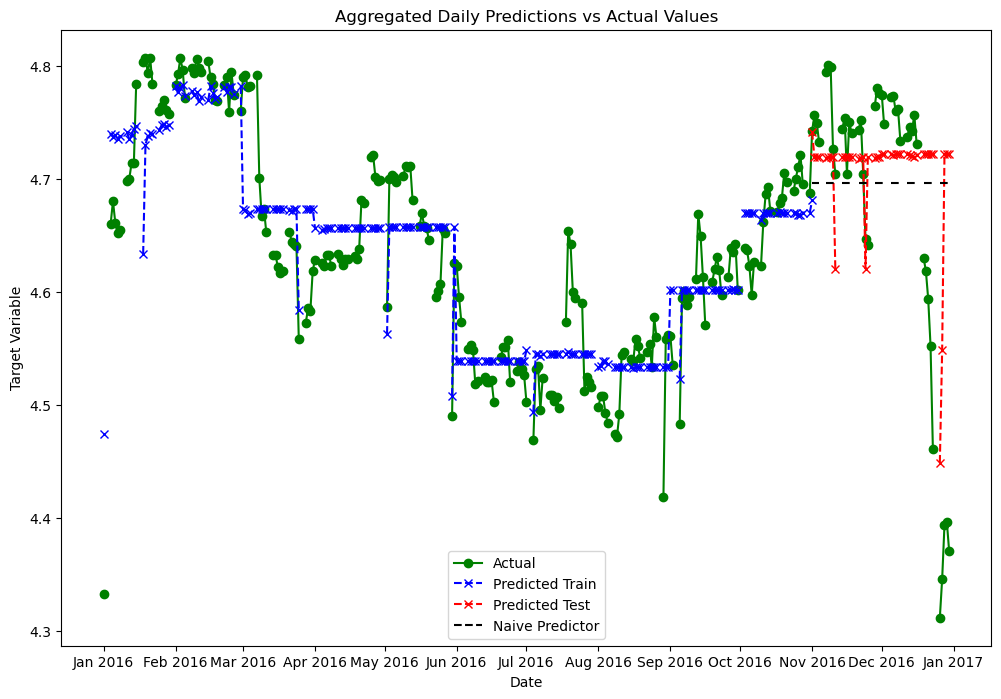

In [71]:
i = 0  # Start fold index from 1

# Lists to store results
all_actual_data = []
all_predicted_data = []
all_plot_paths = []

for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i+1)
    print('Train: ', df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ', df_test['timestamp'].min(), df_test['timestamp'].max()) 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = models[i]
    i = i+1
    XGB.fit(X_train, y_train)
    
    y_pred_train = XGB.predict(X_train)
    y_pred_test = XGB.predict(X_test)


    last_month_mean = df_train[df_train['timestamp'].dt.month == df_train['timestamp'].max().month][target].mean()

    # DataFrames to store aggregated values for the current fold
    aggregated_actual_df = pd.concat([pd.DataFrame({'timestamp': df_train['timestamp'], 'actual': y_train}),
                                      pd.DataFrame({'timestamp': df_test['timestamp'], 'actual': y_test})])

    aggregated_predicted_df = pd.concat([pd.DataFrame({'timestamp': df_train['timestamp'], 'predicted_train': y_pred_train}),
                                         pd.DataFrame({'timestamp': df_test['timestamp'], 'predicted_test': y_pred_test}),
                                         pd.DataFrame({'timestamp': df_test['timestamp'], 'naive_prediction_test': last_month_mean})])

    # Group by timestamp and resample on a daily basis
    aggregated_actual_df.set_index('timestamp', inplace=True)
    aggregated_predicted_df.set_index('timestamp', inplace=True)

    aggregated_actual_daily = aggregated_actual_df.resample('D').mean()
    aggregated_predicted_daily = aggregated_predicted_df.resample('D').mean()

    last_month_mean_array = np.repeat(last_month_mean, len(df_test))

    # Plotting aggregated daily predictions for the current fold
    plt.figure(figsize=(12, 8))
    plt.plot(aggregated_actual_daily.index, aggregated_actual_daily['actual'], label='Actual', marker='o', color='green')
    plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_train'], label='Predicted Train', marker='x', linestyle='--', color='blue')

    if (i==5):
        plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_test'], label='Predicted Test', marker='x', linestyle='--', color='red')
        plt.title(f'Aggregated Daily Predictions vs Actual Values')
    else:
        plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_test'], label='Predicted Validation', marker='x', linestyle='--', color='red')
        plt.title(f'Aggregated Daily Predictions vs Actual Values')

       # Plot naive predictor predictions for the mean of the last month of training data
    plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['naive_prediction_test'], color='black', linestyle='--', label='Naive Predictor')

    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.legend()
    # Format x-axis ticks as months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())    

    plt.show()

    # Save actual and predicted data
    actual_data_path = f'actual_data_fold_{i + 1}.csv'
    predicted_data_path = f'predicted_data_fold_{i + 1}.csv'

    aggregated_actual_daily.to_csv(actual_data_path)
    aggregated_predicted_daily.to_csv(predicted_data_path)

    all_actual_data.append(actual_data_path)
    all_predicted_data.append(predicted_data_path)

    # Save the plot
    plot_path = f'fold_{i + 1}_plot.png'
    plt.savefig(plot_path)
    plt.close()

    all_plot_paths.append(plot_path)
    
# Save paths to a CSV file with UTF-8 encoding
results_info = pd.DataFrame({
    'actual_data_paths': all_actual_data,
    'predicted_data_paths': all_predicted_data,
    'plot_paths': all_plot_paths
})

results_info.to_csv('results_info.csv', index=False, encoding='utf-8')
    

# Naive Predictor Results

In [72]:
MSE_test_naive = []
R2_test_naive = []
MAE_test_naive = []

tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits

i = 1
for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ',df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ',df_test['timestamp'].min(), df_test['timestamp'].max()) 
    i = i + 1 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    test_error_mse = mean_squared_error(y_test,last_month_mean_array)
    test_error_r2 = r2_score(y_test,last_month_mean_array)
    test_error_mae = mean_absolute_error(y_test,last_month_mean_array)
    

    print("MSE for test set is: ",test_error_mse)

    print("R2 for test set is: ",test_error_r2)

    print("MAE for test set is: ",test_error_mae)

    print("--------------------------------")


    MSE_test_naive.append(test_error_mse)
    R2_test_naive.append(test_error_r2)
    MAE_test_naive.append(test_error_mae)





fold : 1
Train:  2016-01-01 08:00:00 2016-03-02 16:00:00
Test:  2016-03-02 16:00:00 2016-05-03 09:00:00
MSE for test set is:  1.446157642871184
R2 for test set is:  -0.0014511584435410452
MAE for test set is:  0.9555874932504133
--------------------------------
fold : 2
Train:  2016-01-01 08:00:00 2016-05-03 09:00:00
Test:  2016-05-03 09:00:00 2016-07-01 13:00:00
MSE for test set is:  1.80617367705739
R2 for test set is:  -0.005418971822841456
MAE for test set is:  1.0261810508176548
--------------------------------
fold : 3
Train:  2016-01-01 08:00:00 2016-07-01 13:00:00
Test:  2016-07-01 13:00:00 2016-08-31 18:00:00
MSE for test set is:  1.910913762204937
R2 for test set is:  -0.014484453103726258
MAE for test set is:  1.068067014007902
--------------------------------
fold : 4
Train:  2016-01-01 08:00:00 2016-08-31 18:00:00
Test:  2016-08-31 18:00:00 2016-11-01 12:00:00
MSE for test set is:  1.6224624522978122
R2 for test set is:  -0.0021641968807530887
MAE for test set is:  0.98045

# Error Comparison

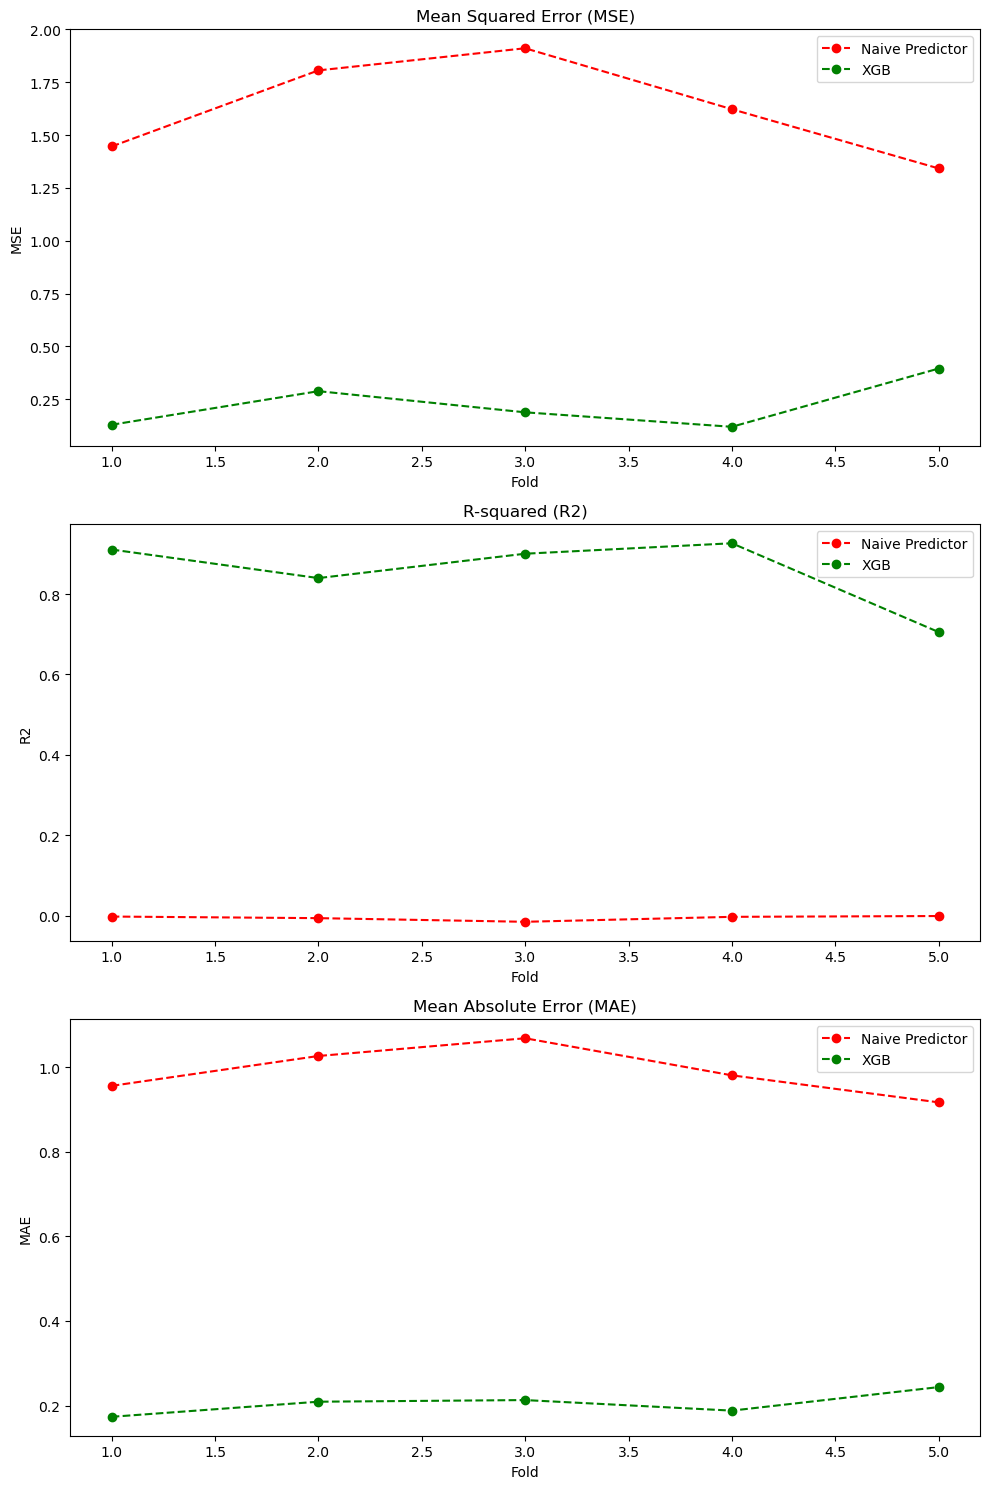

In [73]:
# Plotting errors
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot MSE
axes[0].plot(range(1, 6), MSE_test_naive, marker='o', linestyle='--', color='red', label='Naive Predictor')
axes[0].plot(range(1, 6), MSE_test, marker='o', linestyle='--', color='green', label='XGB')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('MSE')
axes[0].legend()

# Plot R2
axes[1].plot(range(1, 6), R2_test_naive, marker='o', linestyle='--', color='red', label='Naive Predictor')
axes[1].plot(range(1, 6), R2_test, marker='o', linestyle='--', color='green', label='XGB')
axes[1].set_title('R-squared (R2)')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('R2')
axes[1].legend()

# Plot MAE
axes[2].plot(range(1, 6), MAE_test_naive, marker='o', linestyle='--', color='red', label='Naive Predictor')
axes[2].plot(range(1, 6), MAE_test, marker='o', linestyle='--', color='green', label='XGB')
axes[2].set_title('Mean Absolute Error (MAE)')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('MAE')
axes[2].legend()

plt.tight_layout()
plt.show()

# Save model for best hyperparameters and for train&test set

In [74]:
utils.save_model(models[4],"XGB_v2")

In [75]:
import joblib
# Save only the trained model to a file
joblib.dump(XGB, 'trained_model.joblib')

['trained_model.joblib']